In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def parseLogFile( logFile:str ) -> pd.DataFrame:
    # Define column headers and load log file into a pandas dataframe (only keep lines matching "#M")
    def perChList(prefix): return [ f'{prefix}{i}' for i in [12,13,14,15,8,9,10,11,4,5,6,7,0,1,2,3] ]
        # channel order hard-coded to match auto-HV scan log files:
        # $ grep 'HpFT0,HpFT1,HpFT2,HpFT3,HpNT0,HpNT1,HpNT2,HpNT3,HmFT0,HmFT1,HmFT2,HmFT3,HmNT0,HmNT1,HmNT2,HmNT3' AutoScanLogs/*.txt
    cols = ['timestamp', 'ignore'] + perChList('vMon') + perChList('iMon') + perChList('rate') + ['avgRate']
        # [ timestamp, #M, vMon[0:15], iMon[0:15], rate[0:15], avgRate ]
    with open( f'{logFile}', "r" ) as log:
        data = [ line.rstrip( '\n' ).split(',') for num, line in enumerate( log ) if '#M' in line ]
    logData = pd.DataFrame( data, columns = cols )
    logData.timestamp = pd.DatetimeIndex( pd.to_datetime( logData.timestamp, format='%Y.%m.%d %H:%M:%S.%f' ) ).tz_localize('Europe/Amsterdam').tz_convert('UTC')
        # convert timestamps from local CERN time to UTC
        # pd.tz_localize and pd.tz_convert only operate on pd.DatetimeIndex because of reasons [https://stackoverflow.com/a/26090113/13019084]
    floatCol = logData.columns.to_list()[2:]
    logData[floatCol] = logData[floatCol].astype(float)
    return logData

In [10]:
def processChannel( logData:pd.DataFrame, ch:int ) -> pd.DataFrame:
    meanRate, stdevRate, meanCurrent, stdevCurrent = [],[],[],[]
    scanSteps = [50, 60, 70, 80, 90, 100, 125, 150, 175, 200, 225, 250]
    #print(logData)
    logDataCh = logData[['timestamp', f'vMon{ch}', f'iMon{ch}', f'rate{ch}']]
    
    for i,_ in enumerate(scanSteps):
        logDataChStep = logDataCh[ (logDataCh[f'vMon{ch}']<=scanSteps[i]+2) & (logDataCh[f'vMon{ch}']>=scanSteps[i]-2) ]
        
        meanRate.append(logDataChStep[f'rate{ch}'].mean())
        stdevRate.append(logDataChStep[f'rate{ch}'].std())
        meanCurrent.append(logDataChStep[f'iMon{ch}'].mean())
        stdevCurrent.append(logDataChStep[f'iMon{ch}'].std())
    
    data = list(zip(meanRate, stdevRate, meanCurrent, stdevCurrent))
    cols        = [ f'meanRate{ch}', f'stdevRate{ch}', f'meanCurrent{ch}', f'stdevCurrent{ch}' ]
    scanDataCh  = pd.DataFrame( data, index = scanSteps, columns = cols )
    
    return scanDataCh

In [11]:
dataDir = 'AutoScanLogs'
deplVolt = {}
logFile = f'{dataDir}/Scan_2022_6_24_14_20_9.txt'
print( f'\nprocessing {logFile}...' )

deplVolt[logFile] = []
logData = parseLogFile(logFile)
dateTime = logData.timestamp.iloc[0].strftime( "%Y%m%d.%H%M%S" )


processing AutoScanLogs/Scan_2022_6_24_14_20_9.txt...


In [12]:
scanDataCh = processChannel(logData, 0)

In [13]:
scanDataCh

,meanRate0,stdevRate0,meanCurrent0,stdevCurrent0
50,1498.833333,166.765004,-0.093000,0.009529
60,2463.333333,53.327916,-0.090667,0.003724
70,2930.166667,48.676141,-0.094333,0.003882
80,3020.000000,35.670716,-0.093333,0.002066
90,3137.833333,54.071866,-0.091333,0.004320
100,3165.666667,44.025750,-0.093667,0.001966
125,3054.333333,35.652022,-0.091000,0.001673
150,3094.000000,53.795911,-0.088333,0.003204
175,3046.500000,63.000794,-0.082667,0.014067
200,3009.833333,37.445516,-0.095000,0.009274


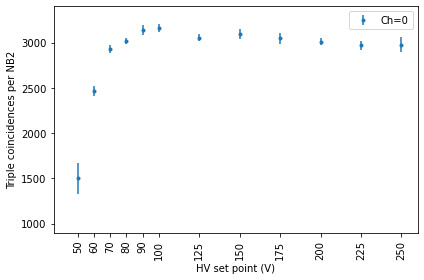

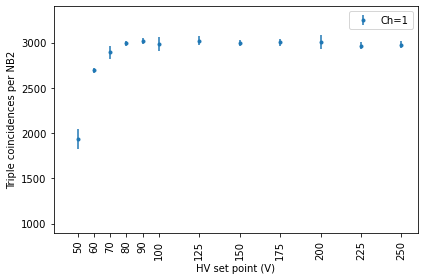

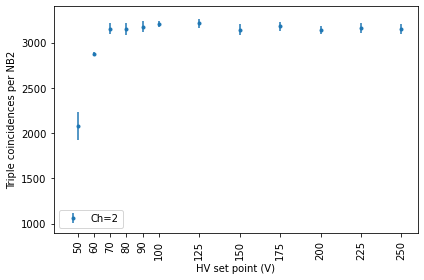

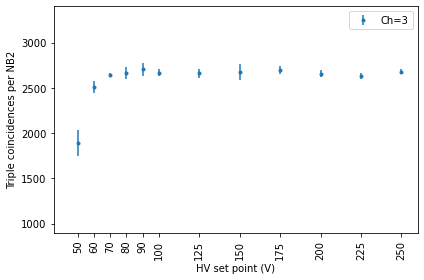

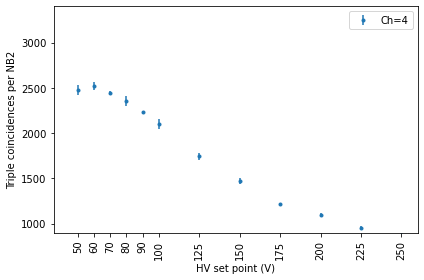

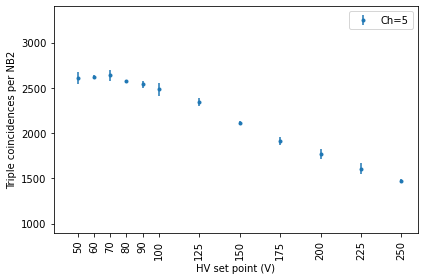

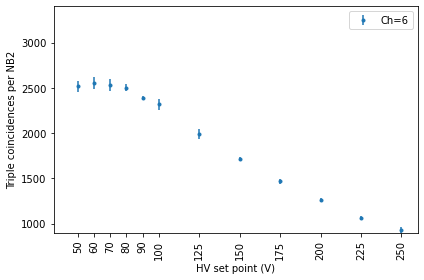

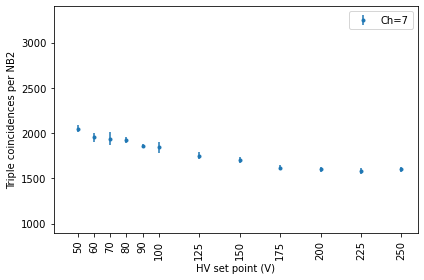

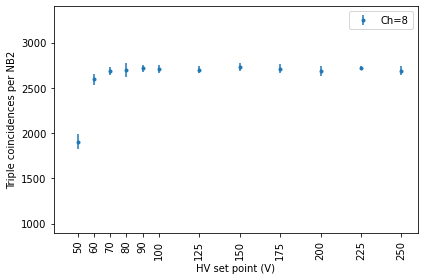

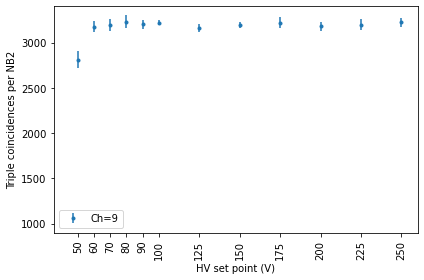

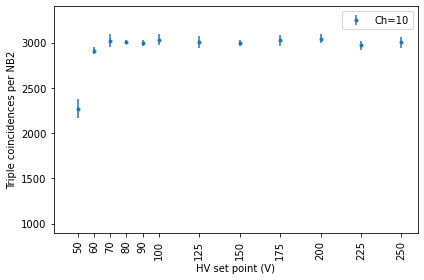

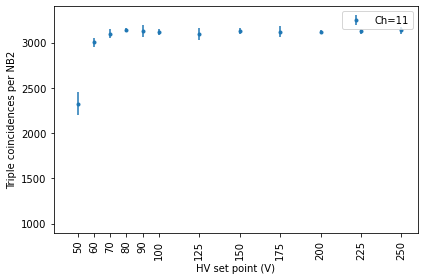

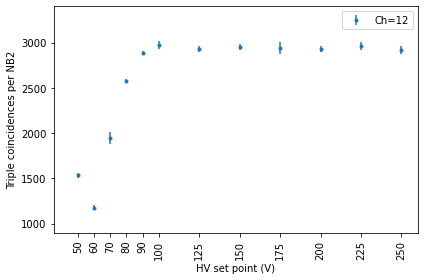

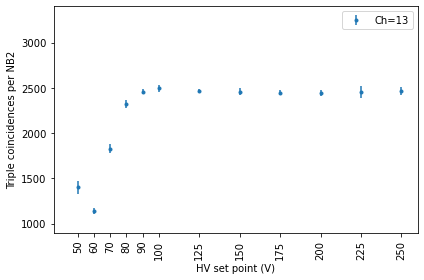

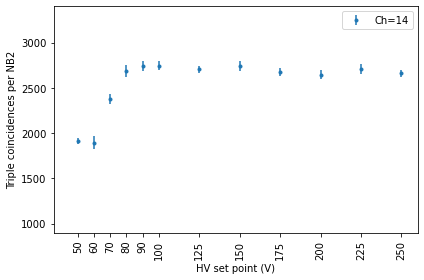

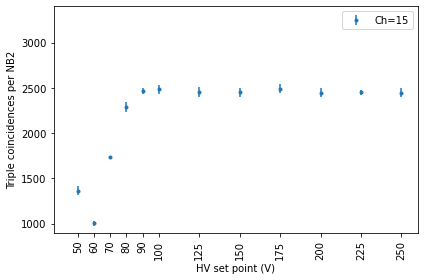

In [33]:
for ch in range(16):
    scanDataCh  = processChannel(logData, ch)
    plt.figure(ch)
    plt.errorbar(x=scanDataCh.index, y=scanDataCh[f'meanRate{ch}'], yerr=scanDataCh[f'stdevRate{ch}'], fmt='.', label=f'Ch={ch}')
    #plt.plot(logData[f'vMon{ch}'], logData[f'rate{ch}'], '.', label=f'Ch={ch}')
    plt.xlim([35, 260])
    plt.ylim([900, 3400])
    plt.xlabel("HV set point (V)")
    plt.ylabel("Triple coincidences per NB2")
    plt.xticks([50, 60, 70, 80, 90, 100, 125, 150, 175, 200, 225, 250], rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"Rate_{ch}.png", dpi=600)

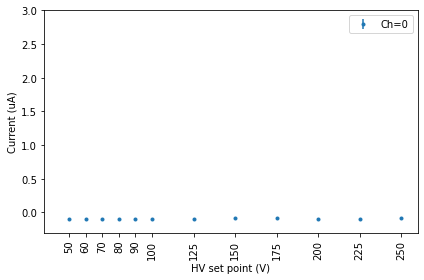

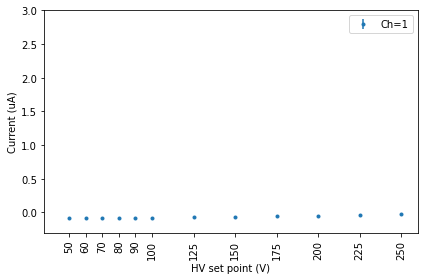

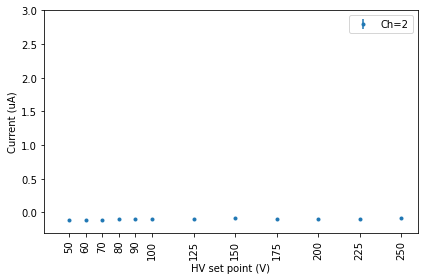

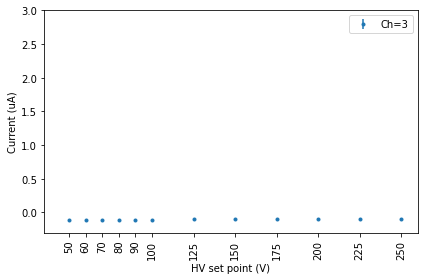

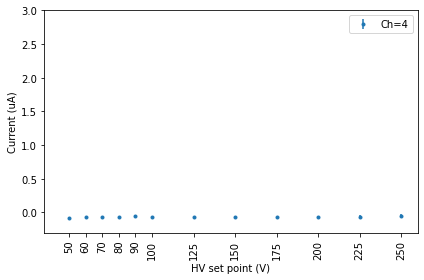

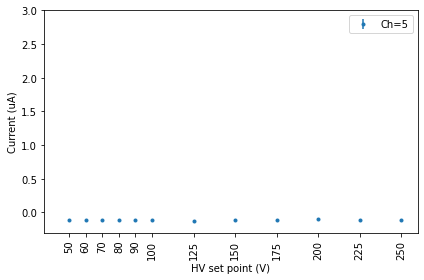

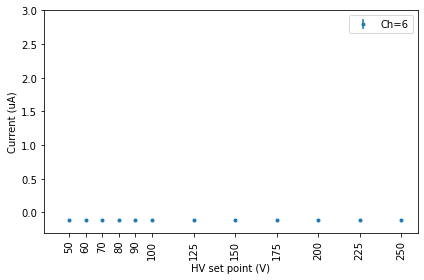

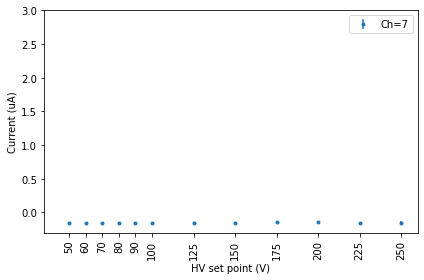

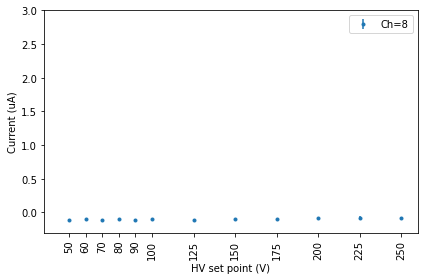

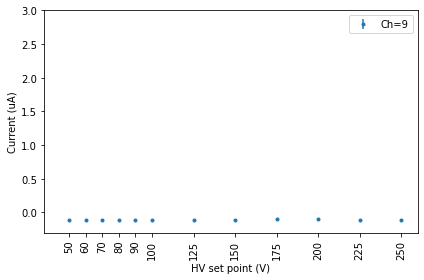

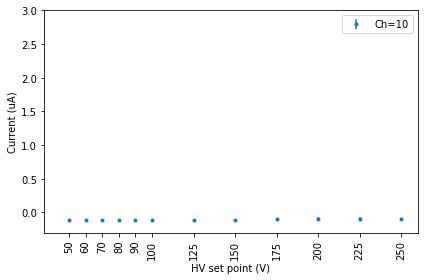

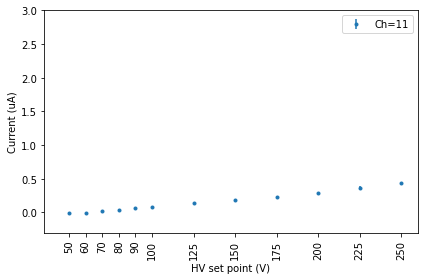

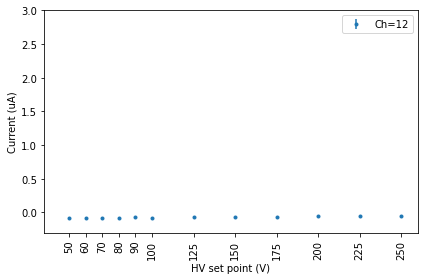

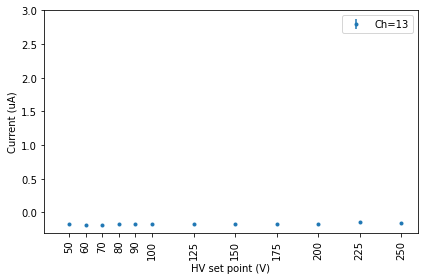

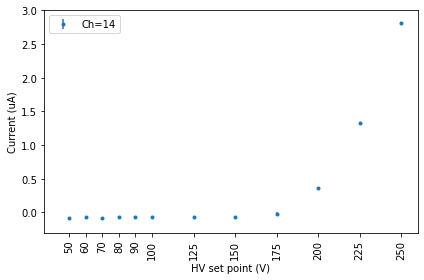

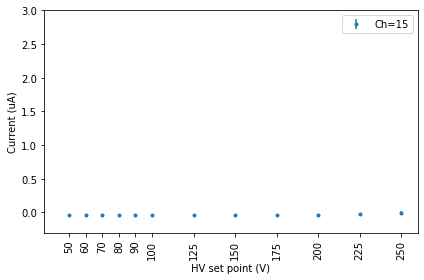

In [32]:
for ch in range(16):
    scanDataCh  = processChannel(logData, ch)
    plt.figure(ch)
    plt.errorbar(x=scanDataCh.index, y=scanDataCh[f'meanCurrent{ch}'], yerr=scanDataCh[f'stdevCurrent{ch}'], fmt='.', label=f'Ch={ch}')
    #plt.plot(logData[f'vMon{ch}'], logData[f'rate{ch}'], '.', label=f'Ch={ch}')
    plt.xlim([35, 260])
    
    #if ch==11 or ch==14:
        #plt.ylim([-0.3, 3])
    plt.ylim([-0.3, 3])
    #else:
        #plt.ylim([-0.2, 0.05])
    plt.xlabel("HV set point (V)")
    plt.ylabel("Current (uA)")
    plt.xticks([50, 60, 70, 80, 90, 100, 125, 150, 175, 200, 225, 250], rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"iMon_{ch}.png", dpi=600)